## RWKV Model block python / triton validation

A much more aggressive, input / output delta comparision for the model input / output between the various time mix kernel implementation

In [1]:
# Configure the parent path to be the proj folder
import sys, os, torch, time
sys.path.append('../../')

# Import the block classes
from rwkv_block.v7_goose.block.rwkv7_layer_block import RWKV7LayerBlock

# File to load
MODEL_FILENAME="v7-1B4.pth"

# Run device, and run dtype to use
RUN_DEVICE="cpu"
RUN_DTYPE=torch.bfloat16

# Check for cuda device
if torch.cuda.is_available():
    RUN_DEVICE="cuda:0"

# Check if the reference weights exists
assert os.path.exists(f"./.model/{MODEL_FILENAME}"), "The reference weights does not exist. Please download it first (00-model-download.ipynb)"

# Loads the model weights
model_weight = torch.load(f"./.model/{MODEL_FILENAME}", map_location='cpu', weights_only=True, mmap=True)

# Model filename
print(f"### Model filename: {MODEL_FILENAME}")

# Lets get the hidden_size, and setup the test module
hidden_size = model_weight['emb.weight'].shape[1]
print(f"### Model hidden_size: {hidden_size}")

# # List the model weights keys, and their shapes
# print(f"### model weights keys:")
# for key in model_weight:
#     print(f"{key}: {model_weight[key].shape} - {model_weight[key].dtype}")

### Model filename: v7-1B4.pth
### Model hidden_size: 2048


In [2]:
# Initialize the channelmix state, and x state to test
IN_TOKENS_LEN=16
x_state_0 = torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
x_state_1 = torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
x_state_2 = torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
cmix_shift_0 = torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
cmix_shift_1 = torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_shift_0 = torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_shift_1 = torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_wkv_0 = torch.ones(1, hidden_size // 64, 64, 64, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_wkv_1 = torch.ones(1, hidden_size // 64, 64, 64, device=RUN_DEVICE, dtype=RUN_DTYPE)

# Iteration to test
TEST_STEPS = 1

# Build the tmix blocks
block_pytorch = RWKV7LayerBlock({ "num_hidden_layers":24, "hidden_size":hidden_size, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"pytorch" })
block_pytorch.load_from_model_state_dict(model_weight, 0)

block_triton = RWKV7LayerBlock({ "num_hidden_layers":24, "hidden_size":hidden_size, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"triton" })
block_triton.load_from_model_state_dict(model_weight, 0)

block_cuda = RWKV7LayerBlock({ "num_hidden_layers":24, "hidden_size":hidden_size, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"cuda" })
block_cuda.load_from_model_state_dict(model_weight, 0)

print(f"### Testing the layer blocks for {TEST_STEPS} steps")

### Testing the layer blocks for 1 steps


In [3]:
### Block
with torch.inference_mode():
    # Input
    block_state_1 = (tmix_shift_1, tmix_wkv_1, cmix_shift_1)

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    block_state_0 = (tmix_shift_0, tmix_wkv_0, cmix_shift_0)
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, block_state_0, v_first = block_pytorch.forward_with_reduce_compile(x_state_1, block_state_1, v_first)
    t2 = time.time()
    print(f'1 block_pytorch reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    block_state_0 = (tmix_shift_0, tmix_wkv_0, cmix_shift_0)
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, block_state_0, v_first = block_pytorch.forward_with_reduce_compile(x_state_1, block_state_1, v_first)
    t2 = time.time()
    print(f'1 block_pytorch reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

1 block_pytorch reduce-compile forward passes (warmup): 3671.6904640197754 ms (cuda:0, torch.bfloat16)
1 block_pytorch reduce-compile forward passes (normal): 1500.6115436553955 ms (cuda:0, torch.bfloat16)


In [4]:
### Block
with torch.inference_mode():
    # Input
    block_state_1 = (tmix_shift_1, tmix_wkv_1, cmix_shift_1)

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    block_state_0 = (tmix_shift_0, tmix_wkv_0, cmix_shift_0)
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, block_state_0, v_first = block_triton.forward_with_reduce_compile(x_state_1, block_state_1, v_first)
    t2 = time.time()
    print(f'1 block_triton reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    block_state_0 = (tmix_shift_0, tmix_wkv_0, cmix_shift_0)
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, block_state_0, v_first = block_triton.forward_with_reduce_compile(x_state_1, block_state_1, v_first)
    t2 = time.time()
    print(f'1 block_triton reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

1 block_triton reduce-compile forward passes (warmup): 1827.0533084869385 ms (cuda:0, torch.bfloat16)
1 block_triton reduce-compile forward passes (normal): 339.86687660217285 ms (cuda:0, torch.bfloat16)


In [5]:
### Block
with torch.inference_mode():
    # Input
    block_state_1 = (tmix_shift_1, tmix_wkv_1, cmix_shift_1)

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    block_state_0 = (tmix_shift_0, tmix_wkv_0, cmix_shift_0)
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, block_state_0, v_first = block_cuda.forward_with_reduce_compile(x_state_1, block_state_1, v_first)
    t2 = time.time()
    print(f'1 block_cuda reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    block_state_0 = (tmix_shift_0, tmix_wkv_0, cmix_shift_0)
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, block_state_0, v_first = block_cuda.forward_with_reduce_compile(x_state_1, block_state_1, v_first)
    t2 = time.time()
    print(f'1 block_cuda reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

Using /home/recursal/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/recursal/.cache/torch_extensions/py312_cu121/wind_backstepping/build.ninja...
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module wind_backstepping...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /usr/bin/nvcc --generate-dependencies-with-compile --dependency-output wkv7_cuda.cuda.o.d -DTORCH_EXTENSION_NAME=wind_backstepping -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include/TH -isystem /home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/include/THC -isystem /home/recursal/miniconda3/envs/py-3-12/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_89,code=compute_89 -gencode=arch=compute_89,code=sm_89 --compiler-o

Using /home/recursal/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module wind_backstepping, skipping build step...
Loading extension module wind_backstepping...


1 block_cuda reduce-compile forward passes (warmup): 2503.4255981445312 ms (cuda:0, torch.bfloat16)


/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/cuda/CUDAGraph.cpp:208.)
  super().capture_end()
/home/recursal/miniconda3/envs/py-3-12/lib/python3.12/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/cuda/CUDAGraph.cpp:208.)
  super().capture_end()


1 block_cuda reduce-compile forward passes (normal): 1146.639108657837 ms (cuda:0, torch.bfloat16)


In [6]:
### TMix
with torch.inference_mode():

    # Get output with python
    py_out_x, py_block_state, py_v_first = block_pytorch.forward(
        torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        (
            torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE), 
            torch.ones(1, hidden_size // 64, 64, 64, device=RUN_DEVICE, dtype=RUN_DTYPE), 
            torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
        ), 
        torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    # Get output with triton
    tr_out_x, tr_block_state, tr_v_first = block_triton.forward(
        torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        (
            torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE), 
            torch.ones(1, hidden_size // 64, 64, 64, device=RUN_DEVICE, dtype=RUN_DTYPE), 
            torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
        ), 
        torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    # Get output with cuda
    cu_out_x, cu_block_state, cu_v_first = block_cuda.forward(
        torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE), 
        (
            torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE), 
            torch.ones(1, hidden_size // 64, 64, 64, device=RUN_DEVICE, dtype=RUN_DTYPE), 
            torch.ones(1, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
        ), 
        torch.ones(1, IN_TOKENS_LEN, hidden_size, device=RUN_DEVICE, dtype=RUN_DTYPE)
    )

    ### (python->triton) 

    # Compute the delta between the two outputs
    py_tr_x = py_out_x - tr_out_x
    py_tr_t_shift = py_block_state[0] - tr_block_state[0]
    py_tr_t_wkv = py_block_state[1] - tr_block_state[1]
    py_tr_c_shift = py_block_state[2] - tr_block_state[2]
    py_tr_v_first = py_v_first - tr_v_first

    # Reshape for display
    delta_tr_x = py_tr_x[-1][-1].view(hidden_size // 64, -1).float().cpu().numpy()
    delta_tr_t_shift = py_tr_t_shift.view(hidden_size // 64, -1).float().cpu().numpy()
    delta_tr_t_wkv = py_tr_t_wkv.view(hidden_size // 64 * 8, -1).float().cpu().numpy()
    delta_tr_c_shift = py_tr_c_shift.view(hidden_size // 64, -1).float().cpu().numpy()
    delta_tr_v_first = py_tr_v_first[-1][-1].view(hidden_size // 64, -1).float().cpu().numpy()

    # Get the abs max delta
    abs_max_delta_tr_x = max(abs(delta_tr_x.max()), abs(delta_tr_x.min()))
    abs_max_delta_tr_t_wkv = max(abs(delta_tr_t_wkv.max()), abs(delta_tr_t_wkv.min()))
    abs_max_delta_tr_t_shift = max(abs(delta_tr_t_shift.max()), abs(delta_tr_t_shift.min()))
    abs_max_delta_tr_c_shift = max(abs(delta_tr_c_shift.max()), abs(delta_tr_c_shift.min()))
    abs_max_delta_tr_v_first = max(abs(delta_tr_v_first.max()), abs(delta_tr_v_first.min()))

    # Compute and print the max/min delta
    print("(python->triton) Max delta for x       (shape:", delta_tr_x.shape," max:", delta_tr_x.max().item(),", min:", delta_tr_x.min().item(),")")
    print("(python->triton) Max delta for t_wkv   (shape:", delta_tr_t_wkv.shape," max:", delta_tr_t_wkv.max().item(),", min:", delta_tr_t_wkv.min().item(),")")
    print("(python->triton) Max delta for t_shift (shape:", delta_tr_t_shift.shape," max:", delta_tr_t_shift.max().item(),", min:", delta_tr_t_shift.min().item(),")")
    print("(python->triton) Max delta for c_shift (shape:", delta_tr_c_shift.shape," max:", delta_tr_c_shift.max().item(),", min:", delta_tr_c_shift.min().item(),")")
    print("(python->triton) Max delta for v_first (shape:", delta_tr_v_first.shape," max:", delta_tr_v_first.max().item(),", min:", delta_tr_v_first.min().item(),")")

    ### (python->cuda)

    # Compute the delta between the two outputs
    py_cu_x = py_out_x - cu_out_x
    py_cu_t_shift = py_block_state[0] - cu_block_state[0]
    py_cu_t_wkv = py_block_state[1] - cu_block_state[1]
    py_cu_c_shift = py_block_state[2] - cu_block_state[2]
    py_cu_v_first = py_v_first - cu_v_first

    # Reshape for display
    delta_cu_x = py_cu_x[-1][-1].view(hidden_size // 64, -1).float().cpu().numpy()
    delta_cu_t_shift = py_cu_t_shift.view(hidden_size // 64, -1).float().cpu().numpy()
    delta_cu_t_wkv = py_cu_t_wkv.view(hidden_size // 64 * 8, -1).float().cpu().numpy()
    delta_cu_c_shift = py_cu_c_shift.view(hidden_size // 64, -1).float().cpu().numpy()
    delta_cu_v_first = py_cu_v_first[-1][-1].view(hidden_size // 64, -1).float().cpu().numpy()

    # Get the abs max delta
    abs_max_delta_cu_x = max(abs(delta_cu_x.max()), abs(delta_cu_x.min()))
    abs_max_delta_cu_t_wkv = max(abs(delta_cu_t_wkv.max()), abs(delta_cu_t_wkv.min()))
    abs_max_delta_cu_t_shift = max(abs(delta_cu_t_shift.max()), abs(delta_cu_t_shift.min()))
    abs_max_delta_cu_c_shift = max(abs(delta_cu_c_shift.max()), abs(delta_cu_c_shift.min()))
    abs_max_delta_cu_v_first = max(abs(delta_cu_v_first.max()), abs(delta_cu_v_first.min()))

    # Compute and print the max/min delta
    print("(python->cuda) Max delta for x       (shape:", delta_cu_x.shape," max:", delta_cu_x.max().item(),", min:", delta_cu_x.min().item(),")")
    print("(python->cuda) Max delta for t_wkv   (shape:", delta_cu_t_wkv.shape," max:", delta_cu_t_wkv.max().item(),", min:", delta_cu_t_wkv.min().item(),")")
    print("(python->cuda) Max delta for t_shift (shape:", delta_cu_t_shift.shape," max:", delta_cu_t_shift.max().item(),", min:", delta_cu_t_shift.min().item(),")")
    print("(python->cuda) Max delta for c_shift (shape:", delta_cu_c_shift.shape," max:", delta_cu_c_shift.max().item(),", min:", delta_cu_c_shift.min().item(),")")
    print("(python->cuda) Max delta for v_first (shape:", delta_cu_v_first.shape," max:", delta_cu_v_first.max().item(),", min:", delta_cu_v_first.min().item(),")")
    

(python->triton) Max delta for x       (shape: (32, 64)  max: 0.015625 , min: -0.03125 )
(python->triton) Max delta for t_wkv   (shape: (256, 512)  max: 0.0078125 , min: -0.0078125 )
(python->triton) Max delta for t_shift (shape: (32, 64)  max: 0.0 , min: 0.0 )
(python->triton) Max delta for c_shift (shape: (32, 64)  max: 0.0234375 , min: -0.04296875 )
(python->triton) Max delta for v_first (shape: (32, 64)  max: 0.0 , min: 0.0 )
(python->cuda) Max delta for x       (shape: (32, 64)  max: 0.0517578125 , min: -0.0625 )
(python->cuda) Max delta for t_wkv   (shape: (256, 512)  max: 0.8125 , min: -1.34375 )
(python->cuda) Max delta for t_shift (shape: (32, 64)  max: 0.0 , min: 0.0 )
(python->cuda) Max delta for c_shift (shape: (32, 64)  max: 0.21875 , min: -0.22265625 )
(python->cuda) Max delta for v_first (shape: (32, 64)  max: 0.0 , min: 0.0 )


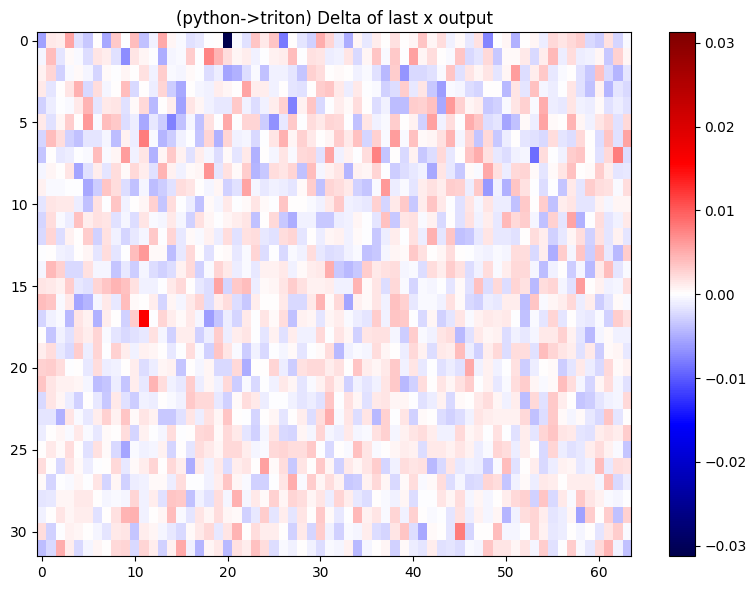

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_x, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_x, abs_max_delta_tr_x)
ax.set_title("(python->triton) Delta of last x output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

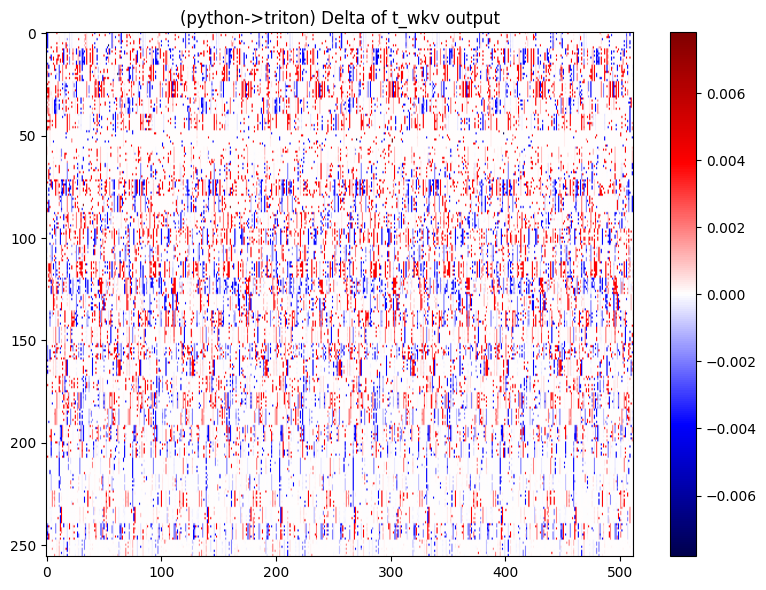

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_t_wkv, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_t_wkv, abs_max_delta_tr_t_wkv)
ax.set_title("(python->triton) Delta of t_wkv output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

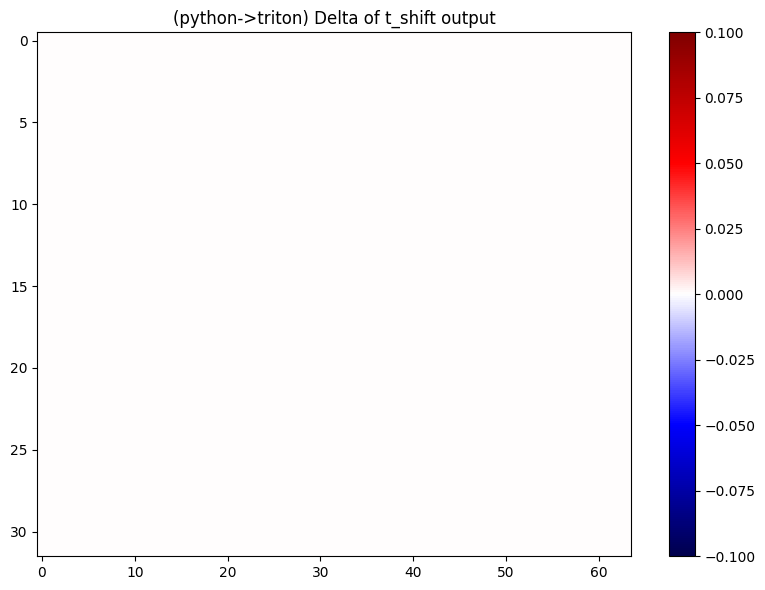

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_t_shift, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_t_shift, abs_max_delta_tr_t_shift)
ax.set_title("(python->triton) Delta of t_shift output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

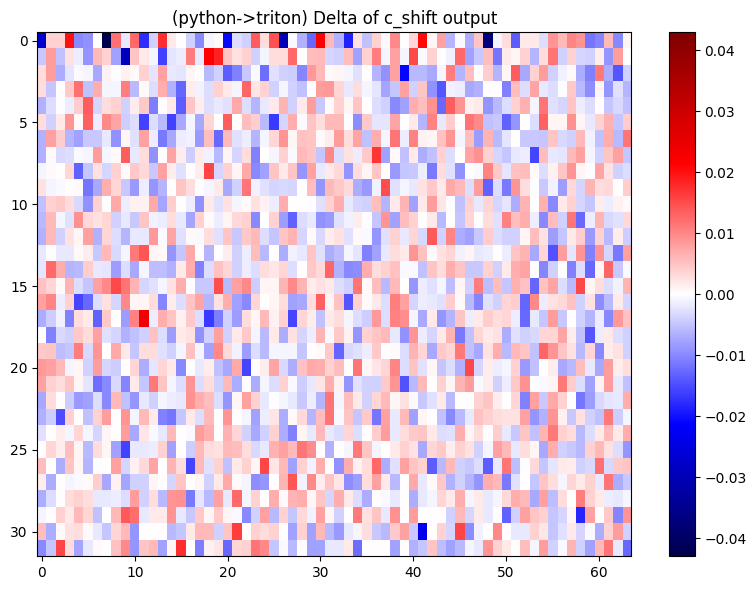

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_c_shift, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_c_shift, abs_max_delta_tr_c_shift)
ax.set_title("(python->triton) Delta of c_shift output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

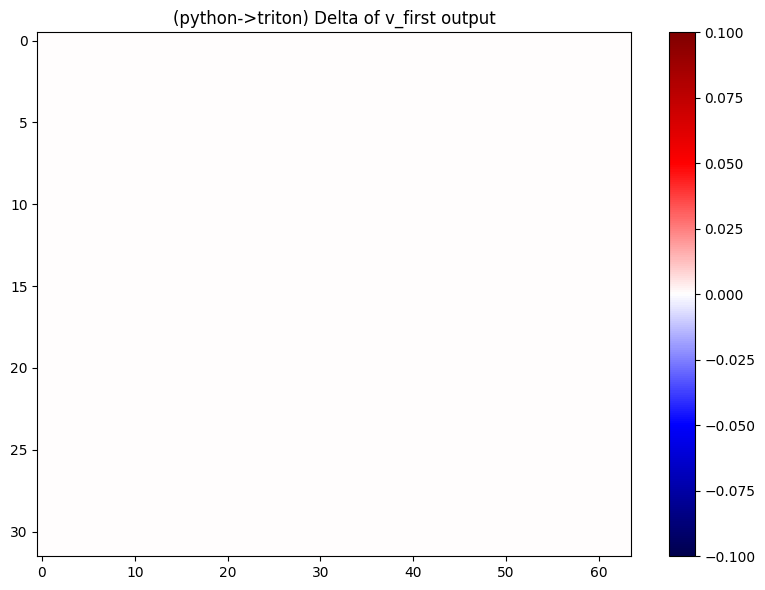

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_v_first, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_v_first, abs_max_delta_tr_v_first)
ax.set_title("(python->triton) Delta of v_first output")
fig.colorbar(im)
fig.tight_layout()
plt.show()